In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

# Getting data

In [5]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [6]:
path.ls

<bound method <lambda> of PosixPath('/home/luan/.fastai/data/biwi_head_pose')>

In [7]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

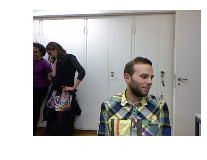

In [8]:
fname = '09/frame_00667_rgb.jpg'
img = open_image(path/fname)
img.show()

In [9]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

In [10]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [11]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [12]:
get_ctr(fname)

tensor([263.9104, 428.5814])

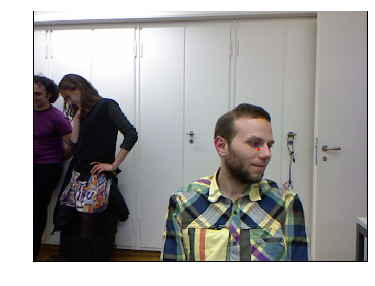

In [13]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

# Dataset

In [14]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

In [15]:
data

ImageDataBunch;

Train: LabelList (15193 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/luan/.fastai/data/biwi_head_pose;

Valid: LabelList (485 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/luan/.fastai/data/biwi_head_pose;

Test: None

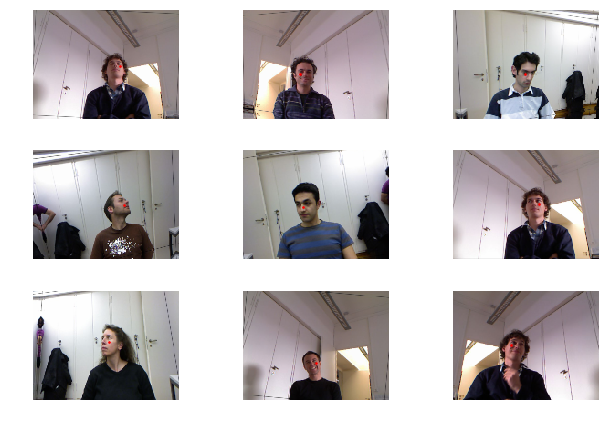

In [16]:
data.show_batch(3, figsize=(9,6))

In [17]:
learn = cnn_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


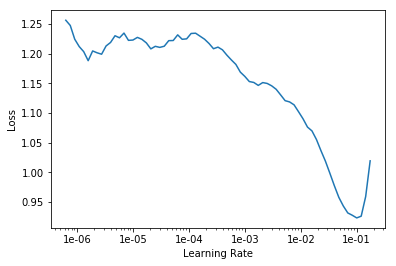

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
lr = 5e-02

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.047743,0.005412,00:36
1,0.011622,0.003844,00:36
2,0.007827,0.001829,00:36
3,0.003754,0.001356,00:36
4,0.002188,0.000630,00:36


In [23]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

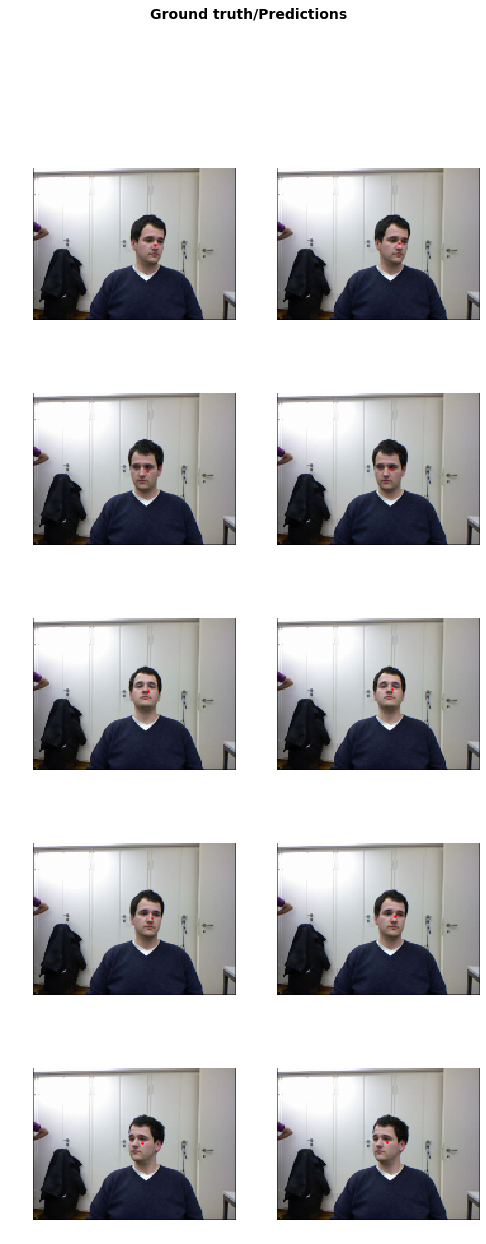

In [21]:
learn.show_results()

# Data Argumentation

In [13]:
tfms = get_transforms(max_rotate=20, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

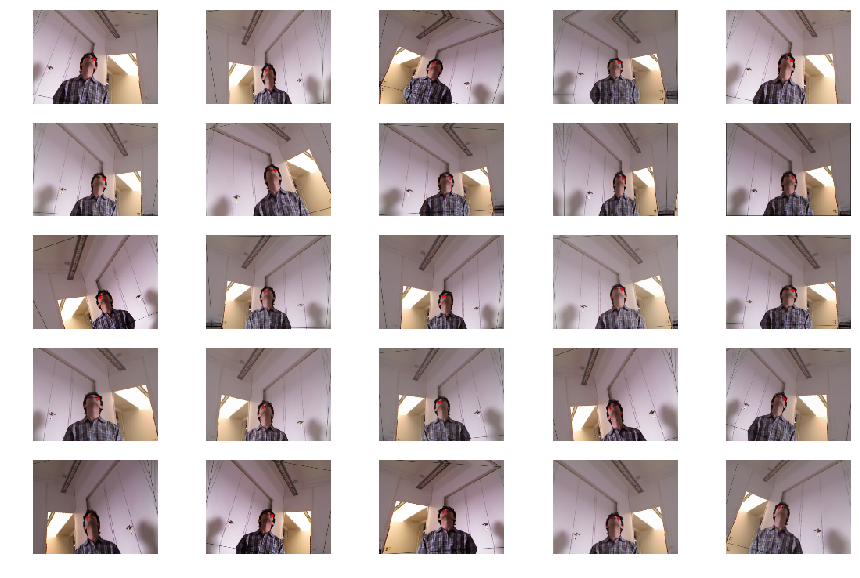

In [16]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 5, 5, figsize=(15,10))

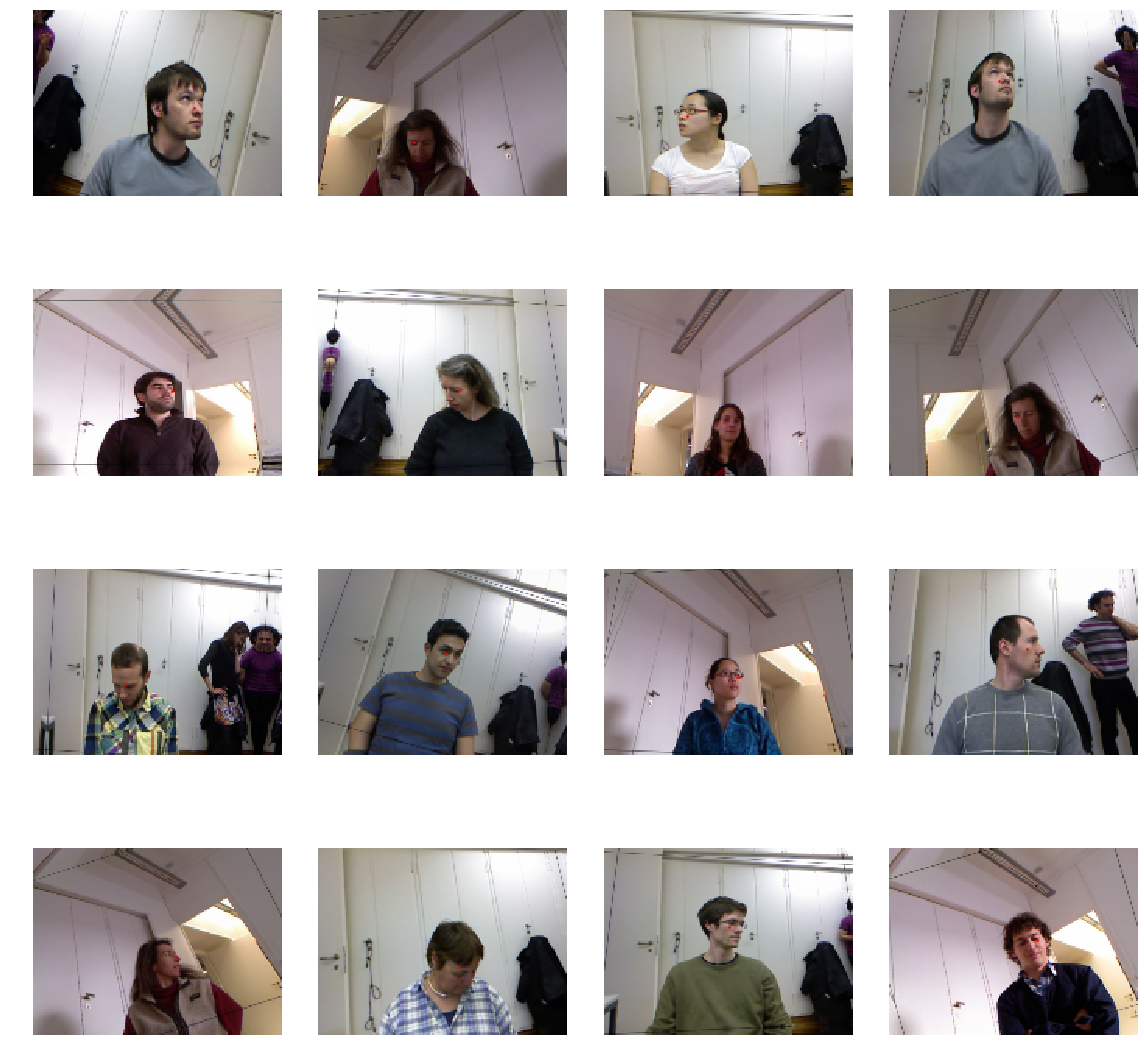

In [15]:
data.show_batch(rows=4)

In [14]:


for i in range(40): 
    idx = next(iter(data.train_dl.batch_sampler))
    samples = [data.train_ds[i] for i in idx]
    
    for element in [o[1].data.shape for o in samples]:
        a1, _ = list(element)
        if (a1 == 0):
            print(element)


In [58]:
idx = next(iter(data.train_dl.batch_sampler))
samples = [data.train_ds[i] for i in idx]
k = [o[1].data.shape for o in samples]

In [66]:
a, _ = list(k[0])
a

1

In [15]:
learn = cnn_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


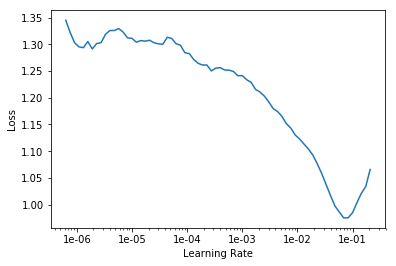

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr = 3e-02

In [18]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,0.064248,0.004212,00:39
1,0.035041,0.004128,00:39
2,0.014277,0.003455,00:39
3,0.010505,0.006409,00:39
4,0.007694,0.007544,00:40
5,0.006400,0.000299,00:39
6,0.004509,0.000940,00:39
7,0.003252,0.001797,00:39
8,0.002531,0.000157,00:39
9,0.002056,0.000118,00:39


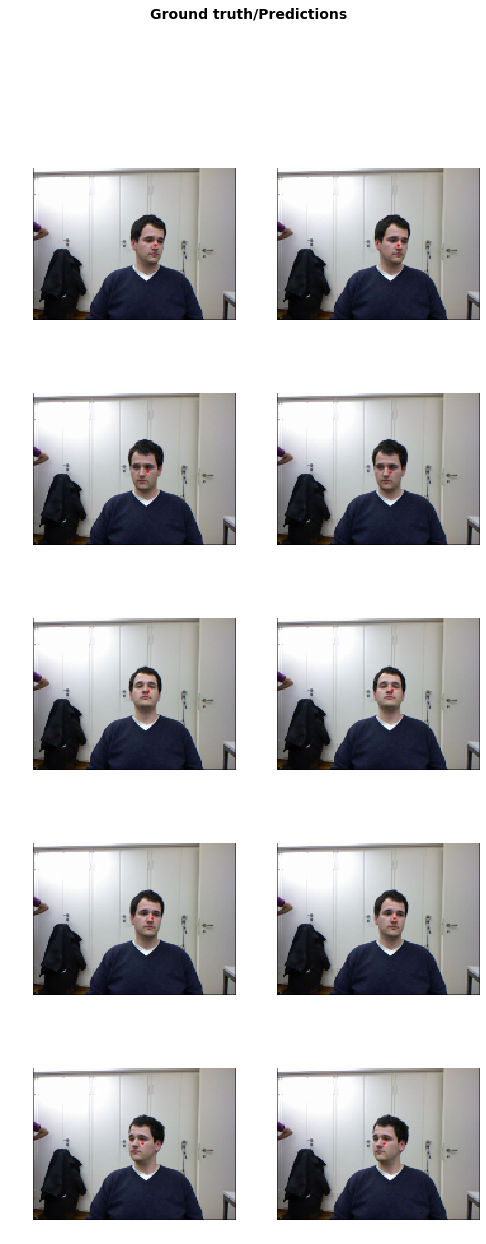

In [19]:
learn.show_results()